In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
dataset_root = '/kaggle/input/collecting-new-breast-diafgnoses/ai_breast_diafgnoses_dataSet_Upload'
carcinoma_dir = os.path.join(dataset_root, 'cc Carcinoma')
normal_dir = os.path.join(dataset_root, 'CC normal')


from pathlib import Path

def is_image_file(file_path):
    return Path(file_path).suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

image_paths = []
labels = []

# Carcinoma = 1, Normal = 0
for path in os.listdir(carcinoma_dir):
    full_path = os.path.join(carcinoma_dir, path)
    if is_image_file(full_path):
        image_paths.append(full_path)
        labels.append(1)

for path in os.listdir(normal_dir):
    full_path = os.path.join(normal_dir, path)
    if is_image_file(full_path):
        image_paths.append(full_path)
        labels.append(0)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 204, Val: 23, Test: 57


In [4]:
class BreastDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        while True:
            img_path = self.dataframe.iloc[idx]['image_path']
            label = self.dataframe.iloc[idx]['label']
            try:
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                return image, label
            except Exception as e:
                print(f"Skipping unreadable image: {img_path}")
                idx = (idx + 1) % len(self.dataframe)  # move to next image


In [5]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = BreastDataset(train_df, transform=transform_train)
val_dataset = BreastDataset(val_df, transform=transform_val_test)
test_dataset = BreastDataset(test_df, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [8]:
def train_model(model, train_loader, val_loader, epochs=10):
    best_val_acc = 0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        scheduler.step()

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        # Record metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [9]:
history = train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10, Loss: 0.1048, Train Acc: 0.9559, Val Acc: 1.0000
Epoch 2/10, Loss: 0.0640, Train Acc: 0.9902, Val Acc: 1.0000
Epoch 3/10, Loss: 0.1449, Train Acc: 0.9559, Val Acc: 1.0000
Epoch 4/10, Loss: 0.0897, Train Acc: 0.9853, Val Acc: 1.0000
Epoch 5/10, Loss: 0.0290, Train Acc: 0.9902, Val Acc: 1.0000
Epoch 6/10, Loss: 0.0166, Train Acc: 0.9951, Val Acc: 1.0000
Epoch 7/10, Loss: 0.0086, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 8/10, Loss: 0.0133, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 9/10, Loss: 0.0145, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10/10, Loss: 0.0088, Train Acc: 1.0000, Val Acc: 1.0000


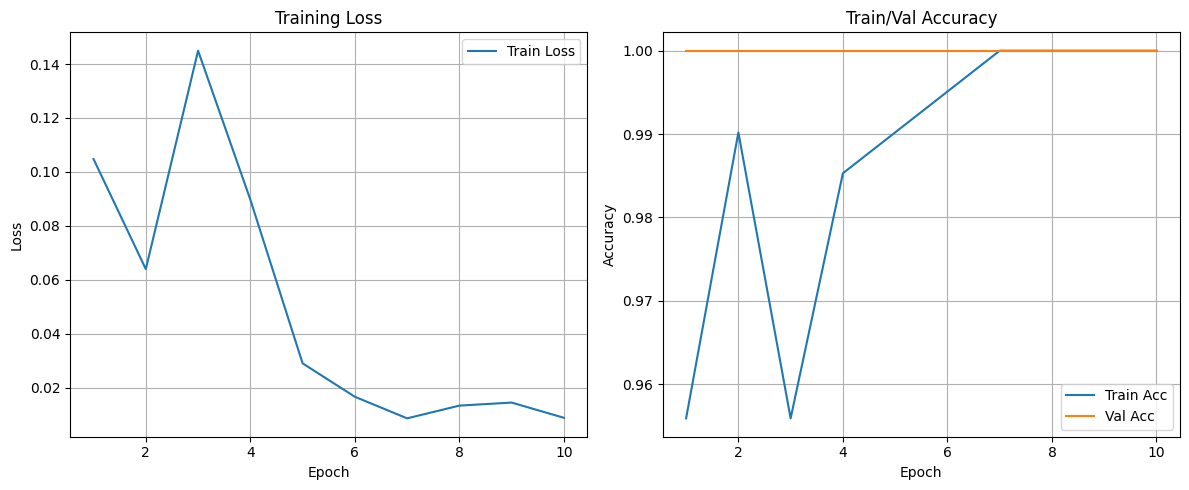

In [10]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Acc')
plt.plot(epochs_range, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
model.eval()
all_preds = []
all_labels = []
total_loss = 0
correct = 0
total = 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_loss = total_loss / total
accuracy = correct / total

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}\n")

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Carcinoma']))


Test Loss: 0.0073
Test Accuracy: 1.0000

Confusion Matrix:
[[31  0]
 [ 0 26]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        31
   Carcinoma       1.00      1.00      1.00        26

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



In [12]:
def plot_predictions(model, dataset, n=15):
    model.eval()
    label_map = {0: 'Normal', 1: 'Carcinoma'}
    
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i in range(n):
        image, label = dataset[i]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            pred = torch.argmax(output, dim=1).item()

        # Unnormalize image for display
        img_display = image.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * 0.5 + 0.5  # Reverse normalization

        axes[i].imshow(img_display)
        axes[i].axis('off')
        axes[i].set_title(f"True: {label_map[label]}\nPred: {label_map[pred]}", fontsize=10)

    plt.tight_layout()
    plt.show()


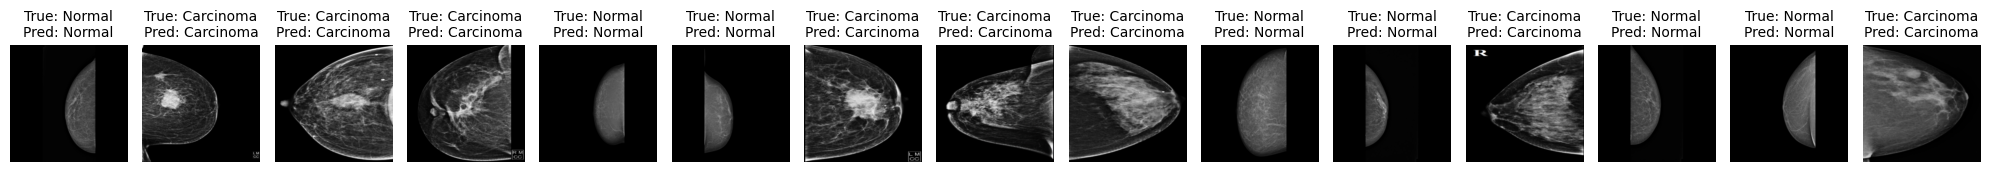

In [13]:
plot_predictions(model, test_dataset)

In [14]:
torch.save(model.state_dict(), "CC_MAMO_breast_cancer_model.pth")